<a href="https://colab.research.google.com/github/pvrohin/raspberry_ros/blob/master/Traffic_sign_detection_left_and_stop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline


Transfer Learning Tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <http://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [0]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [0]:
!cd sample_data

In [3]:
!wget https://zssgua.dm.files.1drv.com/y4mzo2ynXqDrGkNNLpd7Si0g3nlyQmGigZPcZiyOiBx0aUgO460jNmE490ZR4io7MN3MK_42skA8FlScidYpGvGM8veCO-me4Vm8dTfZLtSz_PXAuwKlMO7VpIzjXHvDoaW6u0m2vL0Ni4jZWBRg5Ac3NdrP7Q90W6sE_dTfzhQVFzCfhMFHisGou57cCfP5T95S-wpj7xxbgtuICjoehx7kw/GTSRB.zip?download&psid=1

--2019-12-02 14:44:14--  https://zssgua.dm.files.1drv.com/y4mzo2ynXqDrGkNNLpd7Si0g3nlyQmGigZPcZiyOiBx0aUgO460jNmE490ZR4io7MN3MK_42skA8FlScidYpGvGM8veCO-me4Vm8dTfZLtSz_PXAuwKlMO7VpIzjXHvDoaW6u0m2vL0Ni4jZWBRg5Ac3NdrP7Q90W6sE_dTfzhQVFzCfhMFHisGou57cCfP5T95S-wpj7xxbgtuICjoehx7kw/GTSRB.zip?download
Resolving zssgua.dm.files.1drv.com (zssgua.dm.files.1drv.com)... 13.107.42.12
Connecting to zssgua.dm.files.1drv.com (zssgua.dm.files.1drv.com)|13.107.42.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 364068485 (347M) [application/zip]
Saving to: ‘GTSRB.zip?download’

GTSRB.zip?download  100%[===================>] 347.20M  21.6MB/s    in 21s     

2019-12-02 14:44:36 (16.8 MB/s) - ‘GTSRB.zip?download’ saved [364068485/364068485]



In [13]:
! unzip /content/sample_data/GTSRB_data.zip -d GTRSB_data

Archive:  /content/sample_data/GTSRB_data.zip
   creating: GTRSB_data/GTSRB_data/
   creating: GTRSB_data/GTSRB_data/val/
   creating: GTRSB_data/GTSRB_data/train/
   creating: GTRSB_data/GTSRB_data/val/left_sign/
  inflating: GTRSB_data/GTSRB_data/val/left_sign/00002_00029.ppm  
  inflating: GTRSB_data/GTSRB_data/val/left_sign/00002_00028.ppm  
  inflating: GTRSB_data/GTSRB_data/val/left_sign/00002_00027.ppm  
  inflating: GTRSB_data/GTSRB_data/val/left_sign/00002_00026.ppm  
  inflating: GTRSB_data/GTSRB_data/val/left_sign/00002_00025.ppm  
  inflating: GTRSB_data/GTSRB_data/val/left_sign/00002_00024.ppm  
  inflating: GTRSB_data/GTSRB_data/val/left_sign/00002_00023.ppm  
  inflating: GTRSB_data/GTSRB_data/val/left_sign/00002_00022.ppm  
  inflating: GTRSB_data/GTSRB_data/val/left_sign/00002_00021.ppm  
  inflating: GTRSB_data/GTSRB_data/val/left_sign/00002_00020.ppm  
  inflating: GTRSB_data/GTSRB_data/val/left_sign/00002_00019.ppm  
  inflating: GTRSB_data/GTSRB_data/val/left_sign/

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/GTRSB_data/GTSRB_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



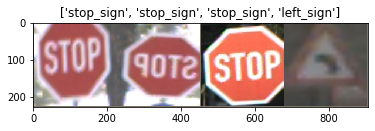

In [17]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 



inputs, classes = next(iter(dataloaders['train']))


out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

      
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0

          
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                
                optimizer.zero_grad()

              
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [20]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()


optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 203MB/s]


Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [21]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.3449 Acc: 0.8238
val Loss: 0.0219 Acc: 1.0000

Epoch 1/24
----------
train Loss: 0.2277 Acc: 0.9016
val Loss: 0.0032 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.3514 Acc: 0.8770
val Loss: 0.0016 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.3746 Acc: 0.8730
val Loss: 0.0008 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.2249 Acc: 0.9139
val Loss: 0.0058 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.2760 Acc: 0.9262
val Loss: 0.0795 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.5105 Acc: 0.8934
val Loss: 0.0008 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.1327 Acc: 0.9508
val Loss: 0.0013 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.1847 Acc: 0.9221
val Loss: 0.0008 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.1910 Acc: 0.9221
val Loss: 0.0008 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.2265 Acc: 0.9098
val Loss: 0.0011 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.1128 Acc: 0.9508
val Loss: 0.0007 Acc: 1.0000

Epoch 12/24
----------
t

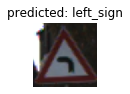

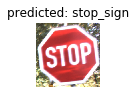

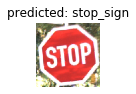

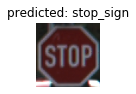

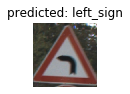

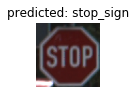

In [22]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False


num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()


optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [28]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.1925 Acc: 0.9262
val Loss: 0.0304 Acc: 0.9933

Epoch 1/49
----------
train Loss: 0.1909 Acc: 0.9426
val Loss: 0.0386 Acc: 0.9867

Epoch 2/49
----------
train Loss: 0.1727 Acc: 0.9344
val Loss: 0.0552 Acc: 1.0000

Epoch 3/49
----------
train Loss: 0.2865 Acc: 0.8607
val Loss: 0.0304 Acc: 0.9867

Epoch 4/49
----------
train Loss: 0.2979 Acc: 0.8607
val Loss: 0.0449 Acc: 1.0000

Epoch 5/49
----------
train Loss: 0.2607 Acc: 0.8852
val Loss: 0.0303 Acc: 0.9933

Epoch 6/49
----------
train Loss: 0.1971 Acc: 0.8934
val Loss: 0.0218 Acc: 1.0000

Epoch 7/49
----------
train Loss: 0.1669 Acc: 0.9262
val Loss: 0.0261 Acc: 0.9933

Epoch 8/49
----------
train Loss: 0.1962 Acc: 0.9016
val Loss: 0.0267 Acc: 1.0000

Epoch 9/49
----------
train Loss: 0.1801 Acc: 0.9180
val Loss: 0.0357 Acc: 0.9933

Epoch 10/49
----------
train Loss: 0.2520 Acc: 0.8770
val Loss: 0.0292 Acc: 0.9867

Epoch 11/49
----------
train Loss: 0.2866 Acc: 0.8648
val Loss: 0.0609 Acc: 0.9800

Ep

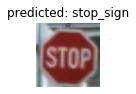

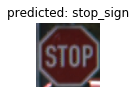

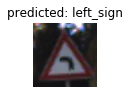

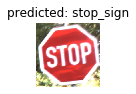

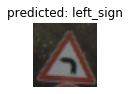

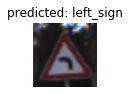

In [29]:
visualize_model(model_conv)

plt.ioff()
plt.show()